**1. Import the requests library**

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from transformers import ViTForImageClassification, ViTImageProcessor
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np

In [6]:
# Load FER-2013 dataset
train_dir = "./data/train"
test_dir = "./data/test"

# Data generators with augmentation
train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    rescale=1./255,
    validation_split=0.2
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    subset='training'
)

valid_generator = valid_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(48, 48),
    batch_size=64,
    color_mode='grayscale',
    class_mode='categorical',
    subset='validation'
)

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [12]:
import os
labels = os.listdir(train_dir)
labels

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

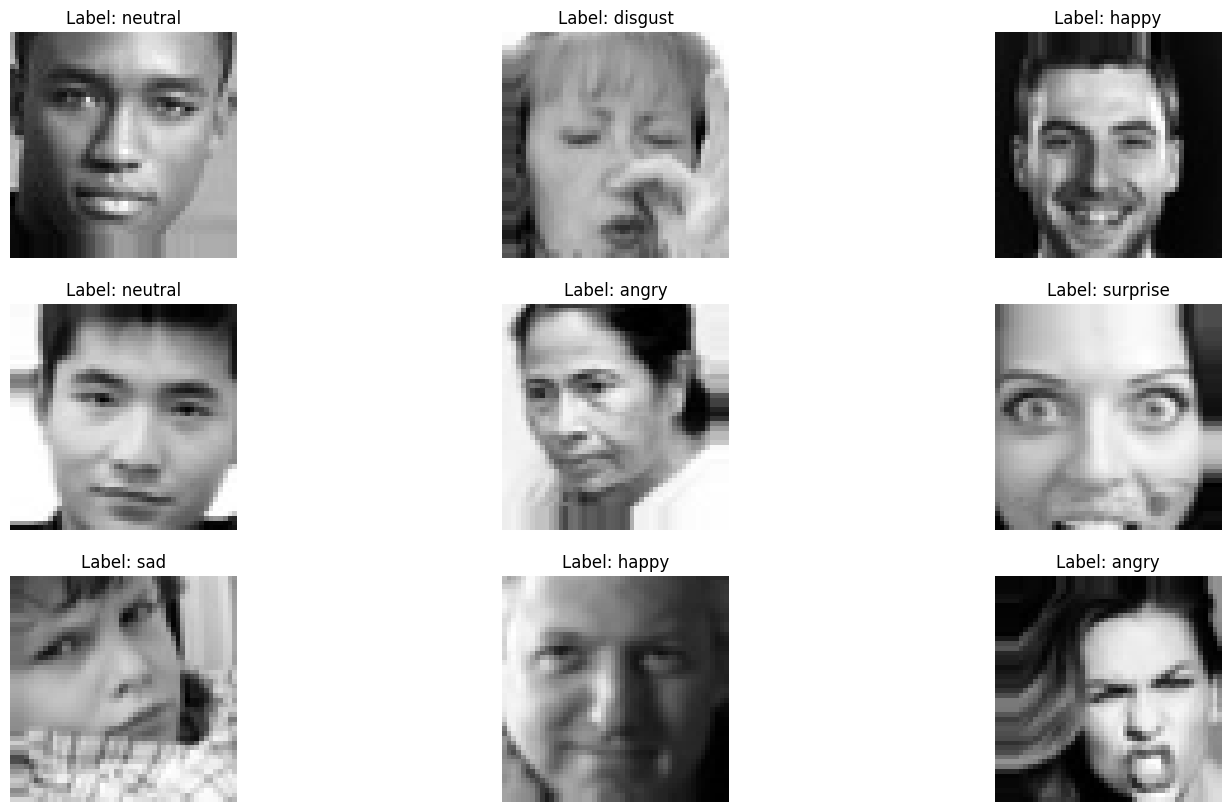

In [17]:
x_batch, y_batch = next(train_generator)
plt.figure(figsize=(18, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_batch[i].reshape(48, 48), cmap='gray')
    label_index = np.argmax(y_batch[i])
    plt.title(f"Label: {labels[label_index]}")
    plt.axis('off')
plt.show()

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [18]:
model_name = 'google/vit-base-patch16-224-in21k'
model = ViTForImageClassification.from_pretrained(model_name, num_labels=7)  # FER-2013 có 7 nhãn
model.to(device)

feature_extractor = ViTImageProcessor.from_pretrained(model_name)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # FER-2013 là ảnh grayscale, cần chuyển thành 3 kênh
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
def train_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images).logits
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)

def eval_model(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images).logits
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()

            _, preds = torch.max(outputs, dim=1)
            correct += torch.sum(preds == labels).item()

    return total_loss / len(dataloader), correct / len(dataloader.dataset)

num_epochs = 4
for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, loss_fn, device)
    val_loss, val_acc = eval_model(model, val_loader, loss_fn, device)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    scheduler.step()
    
torch.save(model.state_dict(), "best_vit_fer2013_model.pt")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4134207].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.4308496].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..1.9428324].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4831376].
Clip

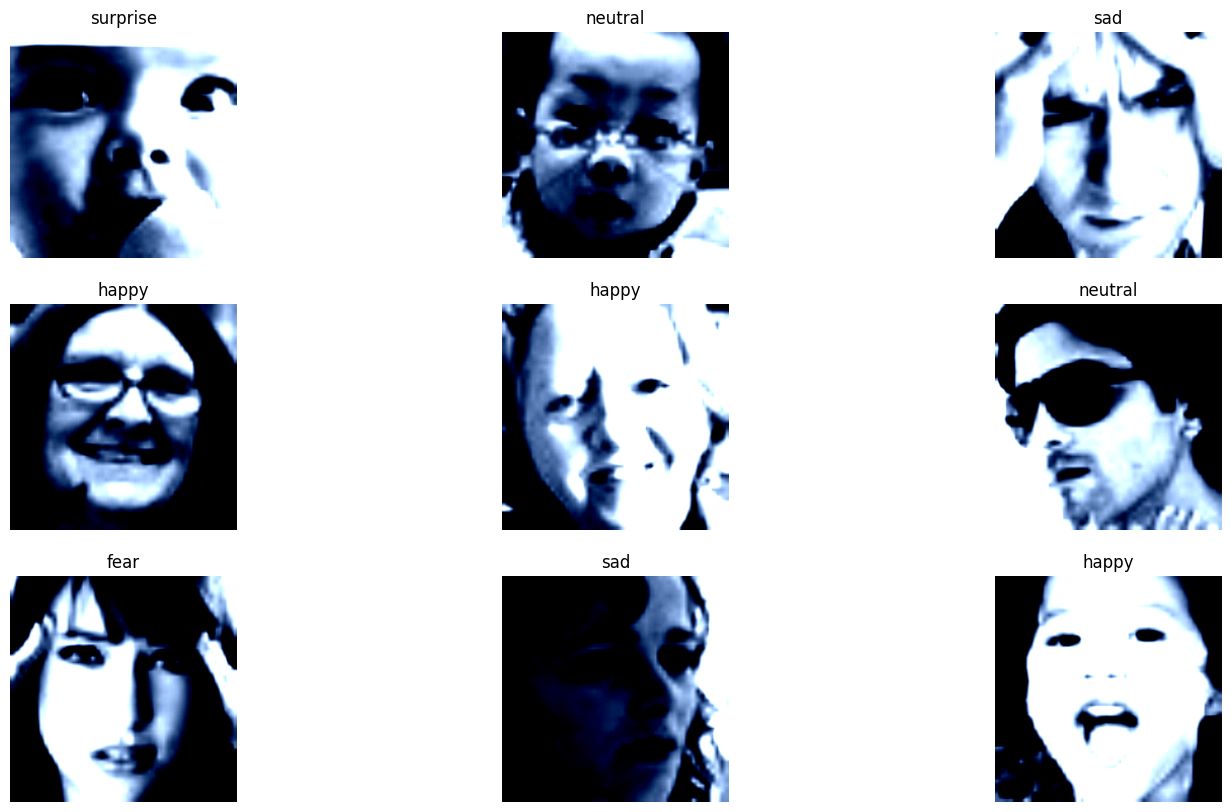

In [21]:
x_batch, y_batch = next(iter(train_loader))
x_batch = x_batch.to('cpu')
batch_size = x_batch.size(0)  

plt.figure(figsize=(18, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(x_batch[i].permute(1, 2, 0).numpy())
    label_index = y_batch[i].item()  
    plt.title(labels[label_index])
    plt.axis('off')
plt.show()
